# Optimal Control Problem

The problem then reduces to finding a pair $(\psi, u)$ that minimizes 
$$
J(\psi, u) = \frac{1}{2} \|\psi(\cdot,T) - \psi^\dagger \|_{L^2(R^d)}^2 + \frac{\nu}{2} \int_0^T \|u(t) \|_2^2 \, dt + \frac{\kappa}{2} \int_0^T \|\psi(\cdot,t) - \hat\psi \|_{L^2(R^d)}^2 \, dt,
$$
where $\psi^\dagger = U^{-1} \rho^\dagger$, subject to the controlled equation
$$
\partial_t \psi = - \mathcal{H} \psi + \sum_{i=1}^m u_i(t) \, \mathcal{N}_i \psi.
$$

In [4]:
import numpy as np
import sympy as sp
from scipy.integrate import dblquad
from scipy.integrate import quad

from schorodinger_operator import WolframNDEigensystemApproximator
from schorodinger_operator import SchrodingerControlSolver

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Example 1: $V(x) = x^2/2$

We start with the simple example $V(x) = x^2 / 2$, which does not show good properties for our puorposes, but might be interesting. 

In [2]:
approximator = WolframNDEigensystemApproximator(
    potential_expr="0.25*x^2-0.5",
    L=10.0,
    N=2000,       
    sigma=1.0,
    options={"MaxCellMeasure": 0.5}
)

def potential(x): return 0.5 * x**2

def rho_0(x):
    return np.exp(-(x + 2.0)**2 / 2) / np.sqrt(2*np.pi)

def rho_dag(x):
    return np.exp(-x**2 / 2 ) / np.sqrt(2*np.pi)

def nabla_alpha(x):
    return np.ones_like(x)

nabla_alpha_list = [nabla_alpha]

solver = SchrodingerControlSolver(
    approximator=approximator,
    num_eigen=20,
    potential=potential,
    rho_0=rho_0,
    rho_dag=rho_dag,
    nu=1e-4,
    nabla_alpha_list=nabla_alpha_list,
    nabla_V=lambda x: x,
    correct_lambda0=True
)

T = 1.0
result_control = solver.solve(T=T, max_iter=500, tol=1e-6, time_eval=np.linspace(0, T, 501), verbose=True, 
                              learning_rate_kwargs={'gamma': 5, 'method': "bb"}, inicialization=True)

result = solver.solve(T=T, max_iter=200, tol=1e-10, time_eval=np.linspace(0, T, 501), verbose=True, 
                      control_funcs=[lambda t: np.zeros_like(t)], optimise=False)

WARNING - Using LQR inicialization
Iteration 1: ||grad|| = 1.861e+01, gamma = 5
Iteration 2: ||grad|| = 1.586e+03, gamma = 0.05800567382324146
Iteration 3: ||grad|| = 1.702e+01, gamma = 0.057389862932456306
Iteration 4: ||grad|| = 1.569e+01, gamma = 0.7363258336184909
Iteration 5: ||grad|| = 5.539e+00, gamma = 1.1381494487103636
Iteration 6: ||grad|| = 2.272e+00, gamma = 1.9298358536866238
Iteration 7: ||grad|| = 3.250e-01, gamma = 2.251888769813736
Iteration 8: ||grad|| = 8.370e-03, gamma = 2.3114211851621675
Iteration 9: ||grad|| = 4.179e-06, gamma = 2.312575306739891
Iteration 10: ||grad|| = 1.102e-07, gamma = 2.31264914981918


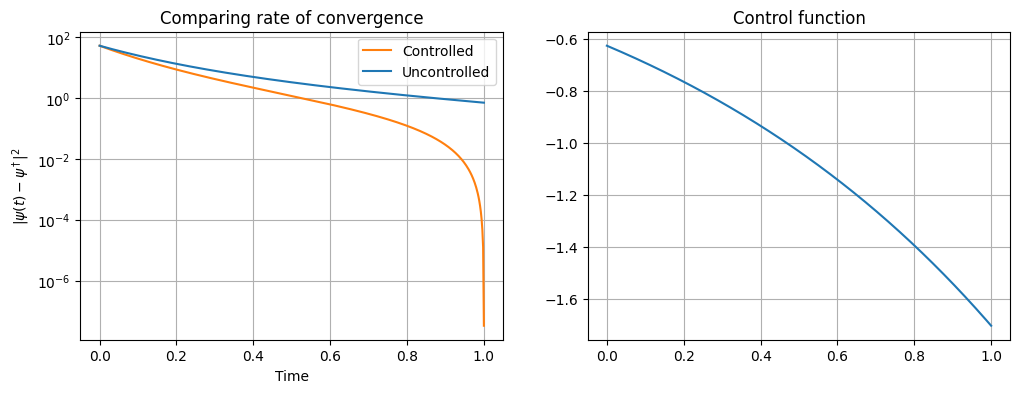

In [3]:
time_grid = result['time']
u_vals = result_control['u_vals'][:, 0]

diff_control = np.trapezoid((result_control['psi'] - solver.rho_infty(solver.x)**(1/2))**2, x=solver.x, axis=1)
diff_nocontrol = np.trapezoid((result['psi'] - solver.rho_infty(solver.x)**(1/2))**2, x=solver.x, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(time_grid, diff_control, label='Controlled', color='C1')
ax[0].plot(time_grid, diff_nocontrol, label='Uncontrolled', color='C0')

ax[0].set_xlabel('Time')
ax[0].set_ylabel(r'$|\psi(t) - \psi^\dagger|^2$')
ax[0].set_title('Comparing rate of convergence')
ax[0].legend()
ax[0].grid(True)
ax[0].set_yscale('log')

ax[1].plot(time_grid, u_vals)
ax[1].grid(True)
ax[1].set_title("Control function")

plt.show()

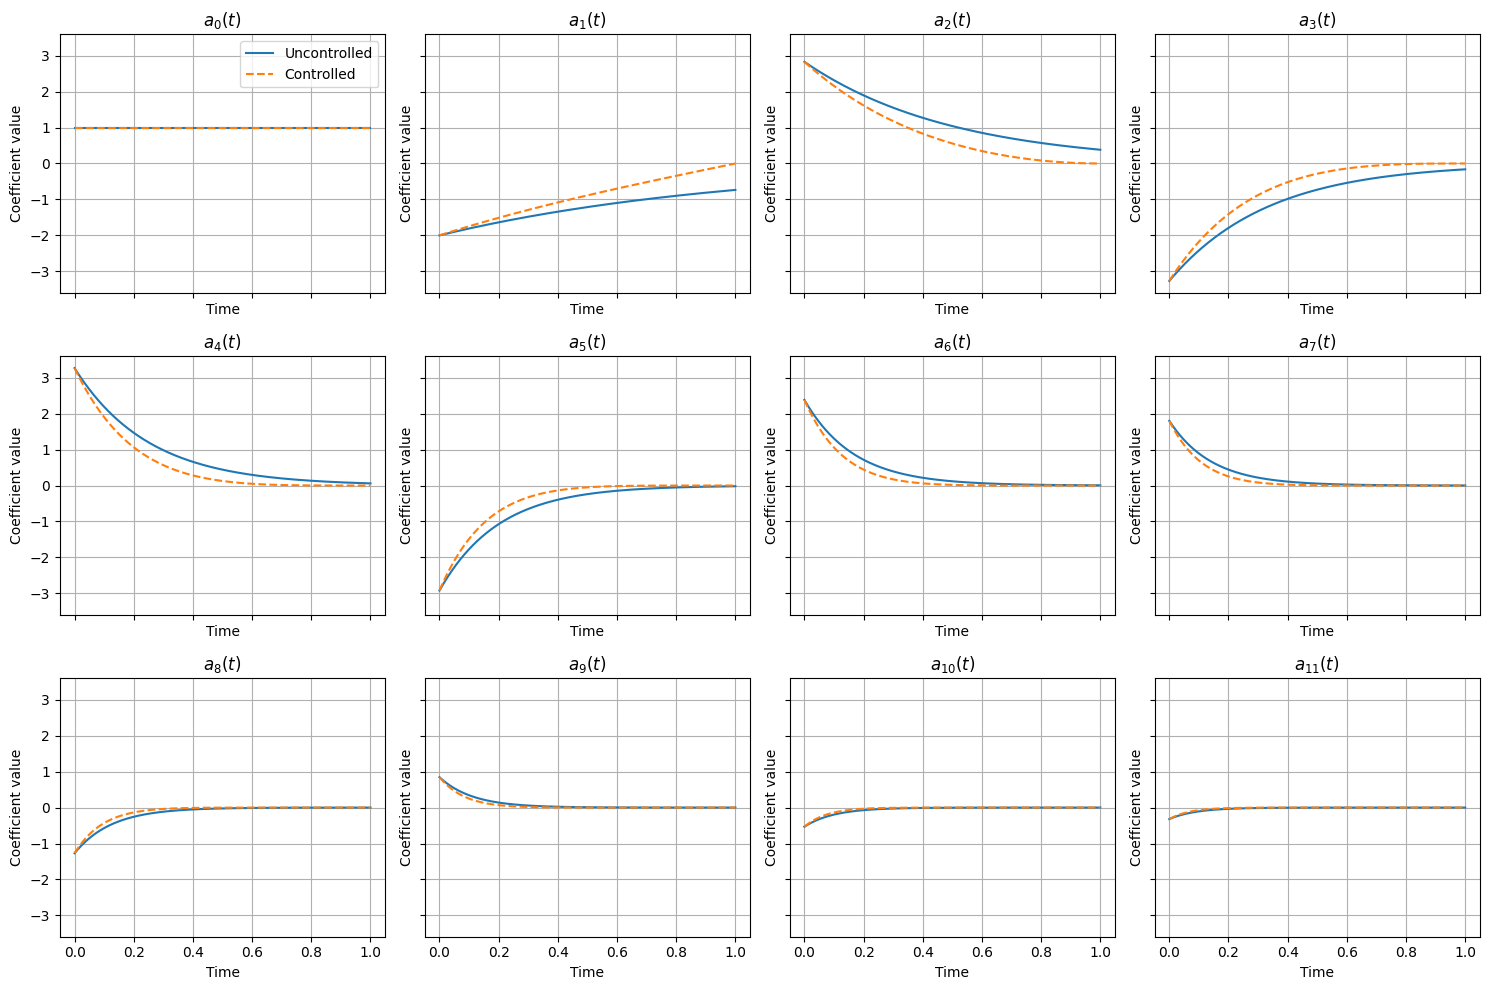

In [4]:
num_plots = 12
rows, cols = 3, 4  # 3 rows x 4 cols = 12 subplots

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(num_plots):
    ax = axes[i]
    ax.plot(time_grid, result['a_vals'][:, i], label='Uncontrolled', color='C0')
    ax.plot(time_grid, result_control['a_vals'][:, i], label='Controlled', color='C1', linestyle='--')
    ax.set_title(f'$a_{{{i}}}(t)$')
    ax.set_xlabel('Time')
    ax.set_ylabel('Coefficient value')
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

## Example 2: $V(x) = (x^2 - 1.5)^2$

In this example, I chose $\alpha$ "smartly".

In [34]:
x = sp.symbols('x')
potential = (x**2 - 1.5)**2

potential_prime = sp.diff(potential, x)
potential_double_prime = sp.diff(potential_prime, x)

expression = 0.25 * potential_prime**2 - 0.5 * potential_double_prime
print(potential_prime.simplify())
print(expression.simplify())

x*(4.0*x**2 - 6.0)
4.0*x**6 - 12.0*x**4 + 3.0*x**2 + 3.0


In [52]:
approximator = WolframNDEigensystemApproximator(
    potential_expr="4*x^6 - 12*x^4 + 3*x^2 + 3",
    L=4.0,
    N=2000,       
    sigma=1.0,
    options={"MaxCellMeasure": 0.05}
)

def potential(x): return (x**2 - 1.5)**2

from scipy.integrate import quad
def _bump_scalar(x):
    """Scalar version for integration."""
    return np.exp(-1/(1 - x**2)) if np.abs(x) < 1 else 0.0
norm, _ = quad(_bump_scalar, -1, 1)
C = 1 / norm
def rho_0(x):
    y = np.zeros_like(x, dtype=float)
    mask = np.abs(x-1) < 1
    y[mask] = C * np.exp(-1/(1 - (x[mask]-1)**2))
    return y
    
def nabla_alpha(x):
    return np.sin(0.5*x)/(1 + x**4)

nabla_alpha_list = [nabla_alpha]

solver1 = SchrodingerControlSolver(
    approximator=approximator,
    num_eigen=50,
    potential=potential,
    rho_0=rho_0,
    rho_dag=None,
    kappa=1.0,
    nu=1e-4,
    nabla_alpha_list=nabla_alpha_list,
    nabla_V=lambda x: 4*(x**2 - 1.5)*x,
    correct_lambda0=True
)

solver2 = SchrodingerControlSolver(
    approximator=approximator,
    num_eigen=50,
    potential=potential,
    rho_0=rho_0,
    rho_dag=None,
    kappa=0.0,
    nu=1e-4,
    nabla_alpha_list=nabla_alpha_list,
    nabla_V=lambda x: 4*(x**2 - 1.5)*x,
    correct_lambda0=True
)

T = 5.0
result_control1 = solver1.solve(T=T, max_iter=500, tol=1e-4, time_eval=np.linspace(0, T, 501), verbose=True,
                                learning_rate_kwargs={'method': 'bb', 'gamma': 10}, inicialization=True,
                               )
result_control2 = solver2.solve(T=T, max_iter=500, tol=1e-4, time_eval=np.linspace(0, T, 501), verbose=True,
                                learning_rate_kwargs={'method': 'bb', 'gamma': 10}, inicialization=False,
                                control_funcs=[lambda t: np.interp(t, np.linspace(0, T, 501), solver1.u_initial.flatten())]
                                )

result_control3 = solver2.solve(T=T, max_iter=500, tol=1e-4, time_eval=np.linspace(0, T, 501), verbose=True,
                                learning_rate_kwargs={'method': 'bb', 'gamma': 10}, inicialization=True,
                                )

result = solver.solve(T=T, max_iter=200, tol=1e-4, time_eval=np.linspace(0, T, 501), verbose=True, 
                      control_funcs=[lambda t: np.zeros_like(t)], optimise=False)

WARNING - Using LQR inicialization
Iteration 1: ||grad|| = 8.219e-01, gamma = 10
Iteration 2: ||grad|| = 7.450e-01, gamma = 92.07366322332557
Iteration 3: ||grad|| = 3.166e-01, gamma = 66.15314961914719
Iteration 4: ||grad|| = 1.184e-01, gamma = 56.42194607042666
Iteration 5: ||grad|| = 7.678e-02, gamma = 69.1893535380594
Iteration 6: ||grad|| = 6.258e-02, gamma = 194.75220923109458
Iteration 7: ||grad|| = 4.287e-02, gamma = 255.19785584099697
Iteration 8: ||grad|| = 4.120e-02, gamma = 141.50132492704597
Iteration 9: ||grad|| = 5.487e-02, gamma = 52.91701327548138
Iteration 10: ||grad|| = 2.846e-02, gamma = 47.91928232016407
Iteration 11: ||grad|| = 2.712e-02, gamma = 76.23520027324255
Iteration 12: ||grad|| = 2.597e-02, gamma = 1107.535952993496
Iteration 13: ||grad|| = 1.886e-02, gamma = 899.2082286325557
Iteration 14: ||grad|| = 1.336e-01, gamma = 63.58292738412453
Iteration 15: ||grad|| = 1.508e-02, gamma = 64.0644036133578
Iteration 16: ||grad|| = 1.367e-02, gamma = 89.26202461608

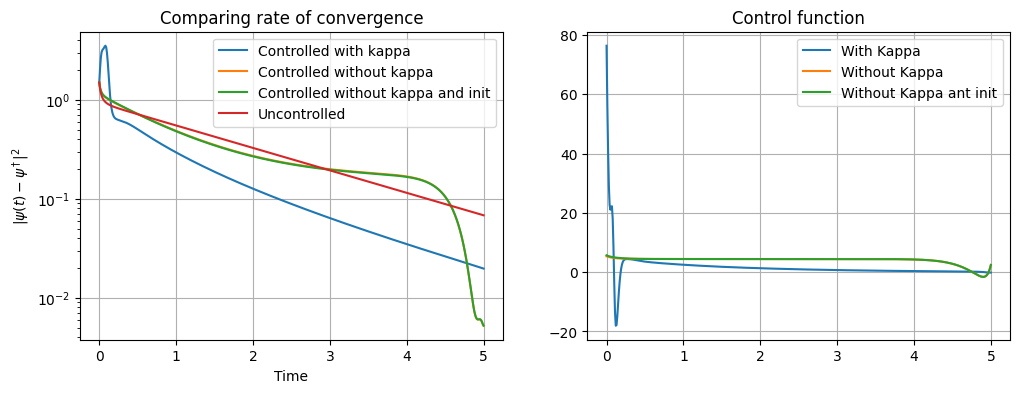

In [54]:
diff_control1 = np.trapezoid((result_control1['psi'] - solver1.rho_infty(solver1.x)**(1/2))**2, x=solver1.x, axis=1)
diff_control2 = np.trapezoid((result_control2['psi'] - solver2.rho_infty(solver2.x)**(1/2))**2, x=solver2.x, axis=1)
diff_control3 = np.trapezoid((result_control3['psi'] - solver2.rho_infty(solver2.x)**(1/2))**2, x=solver2.x, axis=1)
diff_nocontrol = np.trapezoid((result['psi'] - solver1.rho_infty(solver1.x)**(1/2))**2, x=solver1.x, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(result_control1['time'], diff_control1, label='Controlled with kappa')
ax[0].plot(result_control2['time'], diff_control2, label='Controlled without kappa')
ax[0].plot(result_control3['time'], diff_control3, label='Controlled without kappa and init')
ax[0].plot(result['time'], diff_nocontrol, label='Uncontrolled')

ax[0].set_xlabel('Time')
ax[0].set_ylabel(r'$|\psi(t) - \psi^\dagger|^2$')
ax[0].set_title('Comparing rate of convergence')
ax[0].legend()
ax[0].grid(True)
ax[0].set_yscale('log')

ax[1].plot(result_control1['time'], result_control1['u_vals'][:, 0], label="With Kappa")
ax[1].plot(result_control2['time'], result_control2['u_vals'][:, 0], label="Without Kappa")
ax[1].plot(result_control3['time'], result_control3['u_vals'][:, 0], label="Without Kappa ant init")
ax[1].legend()
ax[1].grid(True)
ax[1].set_title("Control function")

plt.show()

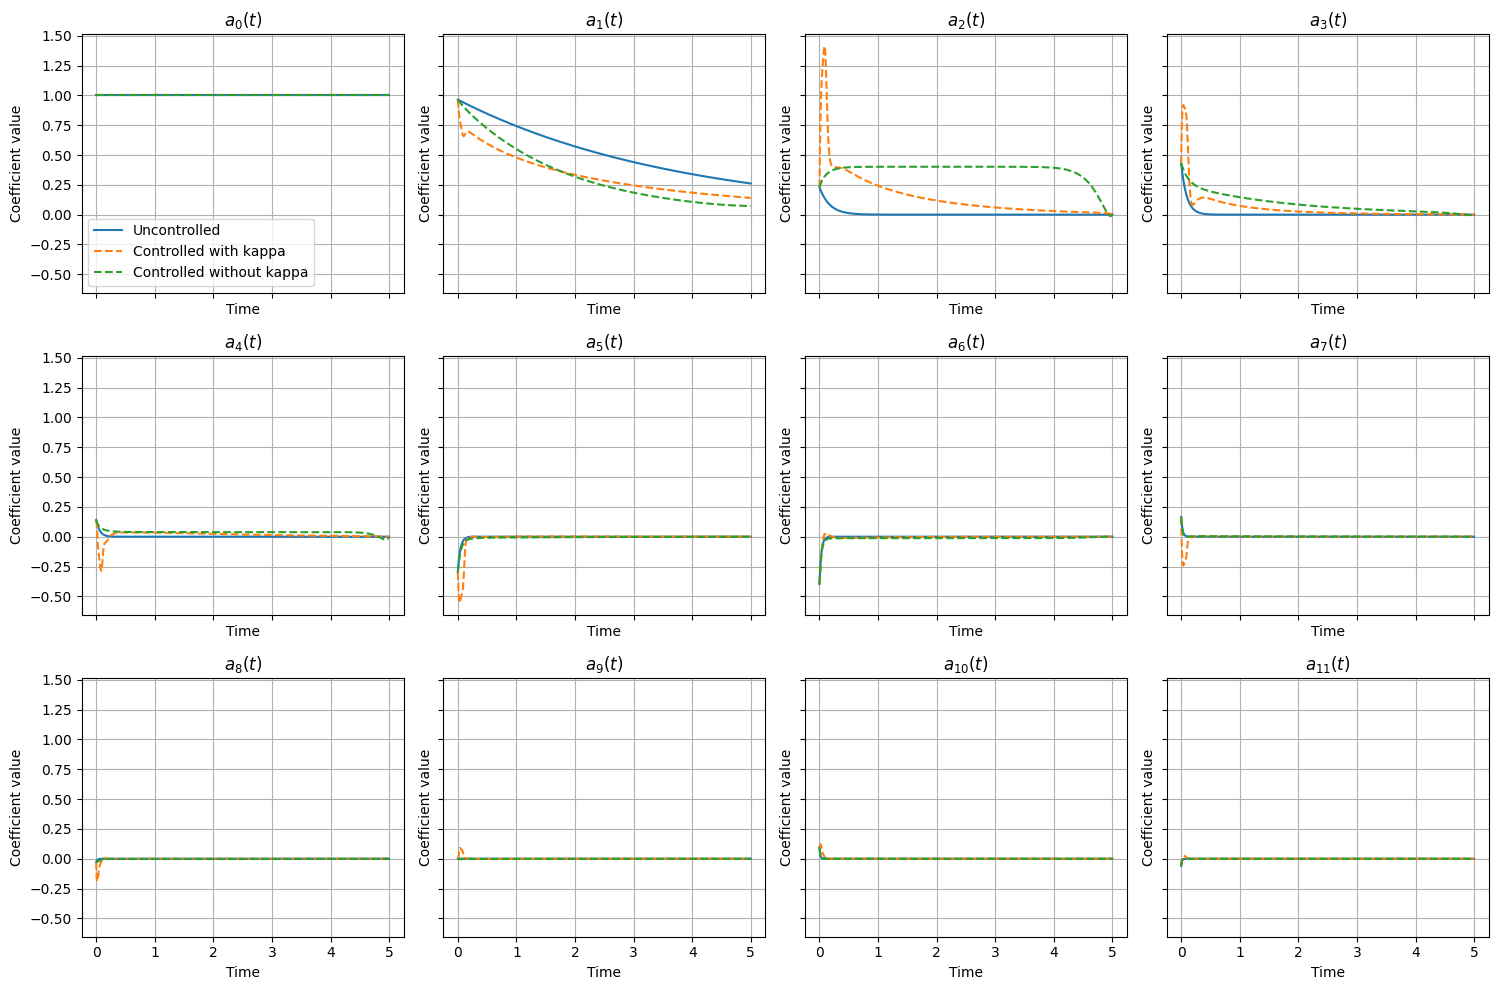

In [58]:
num_plots = 12
rows, cols = 3, 4  # 3 rows x 4 cols = 12 subplots

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(num_plots):
    ax = axes[i]
    ax.plot(result['time'], result['a_vals'][:, i], label='Uncontrolled', color='C0')
    ax.plot(result_control['time'], result_control1['a_vals'][:, i], label='Controlled with kappa', color='C1', linestyle='--')
    ax.plot(result_control['time'], result_control2['a_vals'][:, i], label='Controlled without kappa', color='C2', linestyle='--')
    ax.set_title(f'$a_{{{i}}}(t)$')
    ax.set_xlabel('Time')
    ax.set_ylabel('Coefficient value')
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

### Observing matrix N

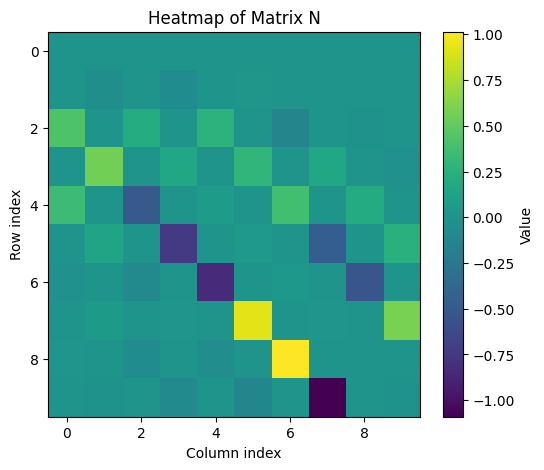

In [64]:
plt.figure(figsize=(6, 5))
plt.imshow(solver1.Delta[0][:10,:10], cmap='viridis', aspect='auto')
plt.colorbar(label='Value')
plt.title('Heatmap of Matrix N')
plt.xlabel('Column index')
plt.ylabel('Row index')
plt.show()

## Example 3: including more controls

Let us include one more control in the same example as before. 

In [93]:
approximator = WolframNDEigensystemApproximator(
    potential_expr="4*x^6 - 12*x^4 + 3*x^2 + 3",
    L=4.0,
    N=5000,       
    sigma=1.0,
    options={"MaxCellMeasure": 0.05}
)

def potential(x): return (x**2 - 1.5)**2

from scipy.integrate import quad
def _bump_scalar(x):
    """Scalar version for integration."""
    return np.exp(-1/(1 - x**2)) if np.abs(x) < 1 else 0.0
norm, _ = quad(_bump_scalar, -1, 1)
C = 1 / norm
def rho_0(x):
    y = np.zeros_like(x, dtype=float)
    mask = np.abs(x-1) < 1
    y[mask] = C * np.exp(-1/(1 - (x[mask]-1)**2))
    return y

nabla_alpha_list = [lambda x: np.sin(0.5*x)/(1 + x**4), # similar to e_1
                    lambda x: (1 - x**2) * np.exp(-x**2 / 2)] # similar to e_2

solver1 = SchrodingerControlSolver(
    approximator=approximator,
    num_eigen=20,
    potential=potential,
    rho_0=rho_0,
    rho_dag=None,
    kappa=1.0,
    nu=1e-4,
    const=1.0,
    nabla_alpha_list=nabla_alpha_list,
    nabla_V=lambda x: 4*(x**2 - 1.5)*x,
    correct_lambda0=True
)

solver2 = SchrodingerControlSolver(
    approximator=approximator,
    num_eigen=20,
    potential=potential,
    rho_0=rho_0,
    rho_dag=None,
    kappa=0.0,
    nu=1e-4,
    const=1.0,
    nabla_alpha_list=nabla_alpha_list,
    nabla_V=lambda x: 4*(x**2 - 1.5)*x,
    correct_lambda0=True
)

T = 5.0
result_control1 = solver1.solve(T=T, max_iter=500, tol=1e-4, time_eval=np.linspace(0, T, 1001), verbose=True,
                                learning_rate_kwargs={'method': 'bb', 'gamma': 10}, inicialization=True,
                               )

result_control2 = solver2.solve(T=T, max_iter=500, tol=1e-4, time_eval=np.linspace(0, T, 1001), verbose=True,
                                learning_rate_kwargs={'method': 'bb', 'gamma': 10}, inicialization=False,
                                control_funcs=[lambda t: np.interp(t, np.linspace(0, T, 1001), result_control1['u_vals'][:, 0].flatten()),
                                              lambda t: np.interp(t, np.linspace(0, T, 1001), result_control1['u_vals'][:, 1].flatten()), 
                                              ]
                                )

result_control3 = solver2.solve(T=T, max_iter=500, tol=1e-4, time_eval=np.linspace(0, T, 1001), verbose=True,
                                learning_rate_kwargs={'method': 'bb', 'gamma': 10}, inicialization=True,
                                )

result = solver1.solve(T=T, max_iter=200, tol=1e-4, time_eval=np.linspace(0, T, 1001), verbose=True, 
                      control_funcs=[lambda t: np.zeros_like(t)], optimise=False)

WARNING - Using LQR inicialization
Iteration 1: ||grad|| = 1.424e-01, gamma = 10
Iteration 2: ||grad|| = 6.909e-02, gamma = 15.628016214135265
Iteration 3: ||grad|| = 3.690e-02, gamma = 29.490266658663565
Iteration 4: ||grad|| = 1.691e-02, gamma = 36.961251694634186
Iteration 5: ||grad|| = 1.247e-02, gamma = 46.72900499333619
Iteration 6: ||grad|| = 2.077e-02, gamma = 11.592163271221649
Iteration 7: ||grad|| = 1.129e-02, gamma = 8.394578457414317
Iteration 8: ||grad|| = 8.327e-03, gamma = 8.794728591182842
Iteration 9: ||grad|| = 8.068e-03, gamma = 175.86760438631677
Iteration 10: ||grad|| = 4.891e-03, gamma = 182.2466833823609
Iteration 11: ||grad|| = 2.560e-02, gamma = 11.277981275561334
Iteration 12: ||grad|| = 1.047e-02, gamma = 8.43254105232328
Iteration 13: ||grad|| = 4.514e-03, gamma = 8.695644265202336
Iteration 14: ||grad|| = 3.949e-03, gamma = 27.43583526246889
Iteration 15: ||grad|| = 3.313e-03, gamma = 30.200953445728743
Iteration 16: ||grad|| = 3.155e-03, gamma = 110.14966

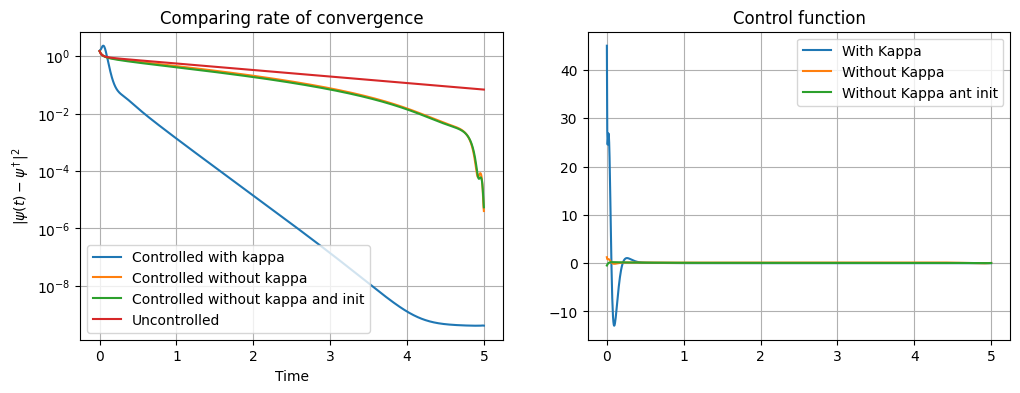

In [94]:
diff_control1 = np.trapezoid((result_control1['psi'] - solver1.rho_infty(solver1.x)**(1/2))**2, x=solver1.x, axis=1)
diff_control2 = np.trapezoid((result_control2['psi'] - solver2.rho_infty(solver2.x)**(1/2))**2, x=solver2.x, axis=1)
diff_control3 = np.trapezoid((result_control3['psi'] - solver2.rho_infty(solver2.x)**(1/2))**2, x=solver2.x, axis=1)
diff_nocontrol = np.trapezoid((result['psi'] - solver1.rho_infty(solver1.x)**(1/2))**2, x=solver1.x, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(result_control1['time'], diff_control1, label='Controlled with kappa')
ax[0].plot(result_control2['time'], diff_control2, label='Controlled without kappa')
ax[0].plot(result_control3['time'], diff_control3, label='Controlled without kappa and init')
ax[0].plot(result['time'], diff_nocontrol, label='Uncontrolled')

ax[0].set_xlabel('Time')
ax[0].set_ylabel(r'$|\psi(t) - \psi^\dagger|^2$')
ax[0].set_title('Comparing rate of convergence')
ax[0].legend()
ax[0].grid(True)
ax[0].set_yscale('log')

ax[1].plot(result_control1['time'], result_control1['u_vals'][:, 0], label="With Kappa")
ax[1].plot(result_control2['time'], result_control2['u_vals'][:, 0], label="Without Kappa")
ax[1].plot(result_control3['time'], result_control3['u_vals'][:, 0], label="Without Kappa ant init")
ax[1].legend()
ax[1].grid(True)
ax[1].set_title("Control function")

plt.show()

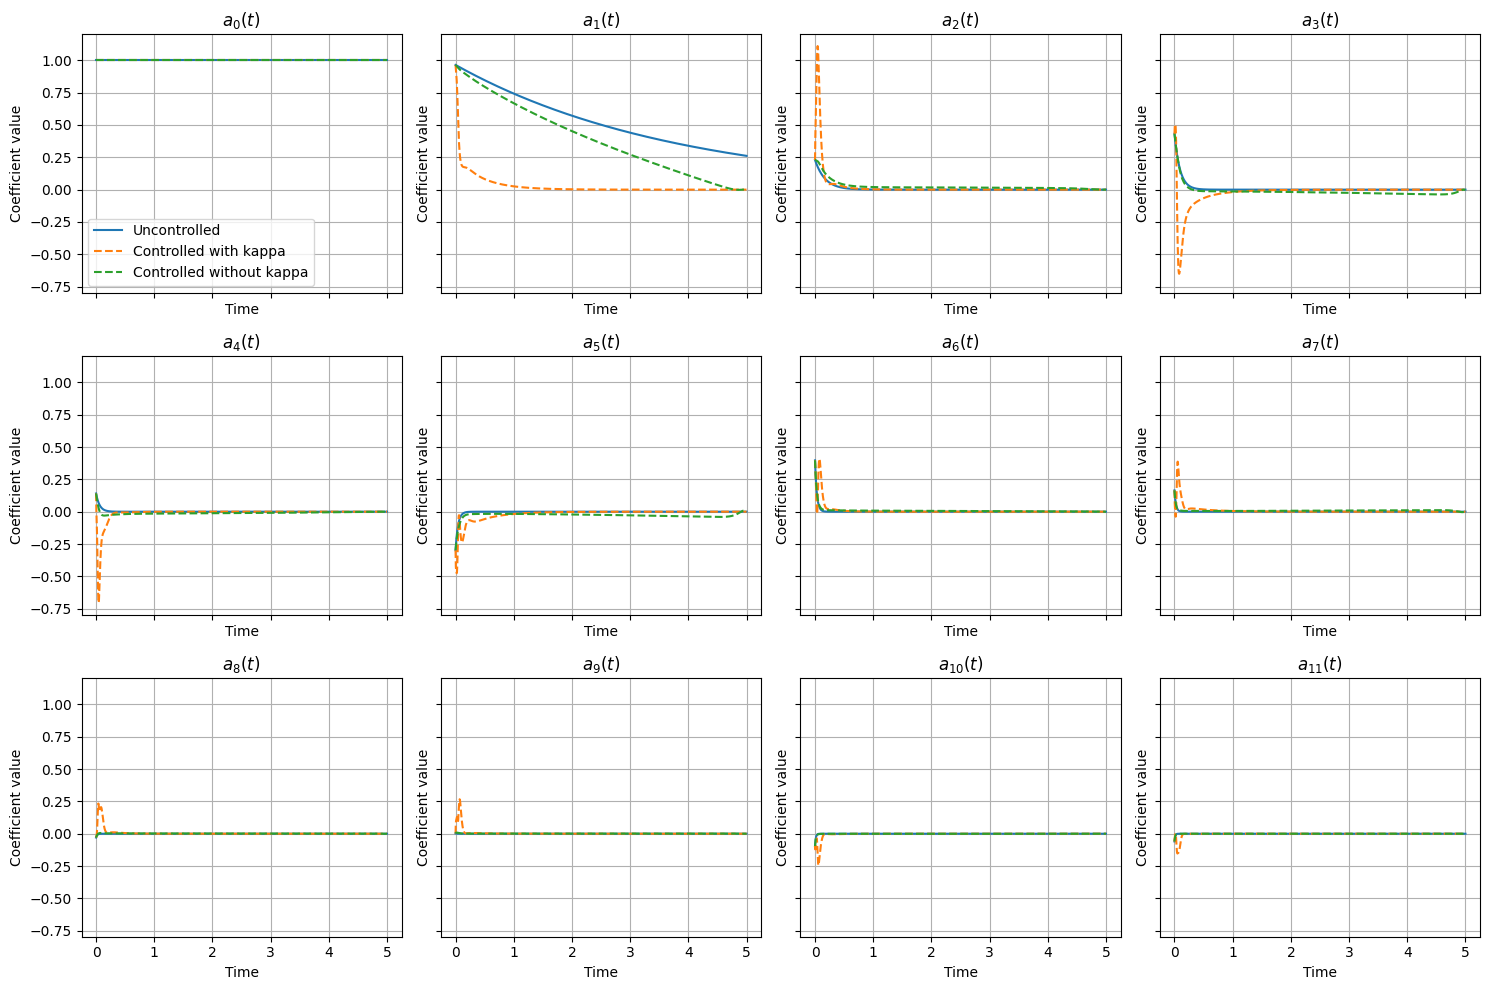

In [96]:
num_plots = 12
rows, cols = 3, 4  # 3 rows x 4 cols = 12 subplots

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(num_plots):
    ax = axes[i]
    ax.plot(result['time'], result['a_vals'][:, i], label='Uncontrolled', color='C0')
    ax.plot(result_control1['time'], result_control1['a_vals'][:, i], label='Controlled with kappa', color='C1', linestyle='--')
    ax.plot(result_control2['time'], result_control2['a_vals'][:, i], label='Controlled without kappa', color='C2', linestyle='--')
    ax.set_title(f'$a_{{{i}}}(t)$')
    ax.set_xlabel('Time')
    ax.set_ylabel('Coefficient value')
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

In [98]:
solver1.compute_cost_functional([lambda t: np.interp(t, np.linspace(0, T, 1001), result_control1['u_vals'][:, 0].flatten()),
                                              lambda t: np.interp(t, np.linspace(0, T, 1001), result_control1['u_vals'][:, 1].flatten()), 
                                ], T, np.linspace(0, T, 1001))

[np.float64(2.8439179241580788e-11),
 np.float64(0.003084772319319296),
 np.float64(0.11146240158837388)]

In [99]:
solver2.compute_cost_functional([lambda t: np.interp(t, np.linspace(0, T, 1001), result_control1['u_vals'][:, 0].flatten()),
                                              lambda t: np.interp(t, np.linspace(0, T, 1001), result_control1['u_vals'][:, 1].flatten()), 
                                ], T, np.linspace(0, T, 1001))

[np.float64(2.8439179241580788e-11),
 np.float64(0.003084772319319296),
 np.float64(0.0)]

In [100]:
solver2.compute_cost_functional([lambda t: np.interp(t, np.linspace(0, T, 1001), result_control3['u_vals'][:, 0].flatten()),
                                              lambda t: np.interp(t, np.linspace(0, T, 1001), result_control3['u_vals'][:, 1].flatten()), 
                                ], T, np.linspace(0, T, 1001))

[np.float64(2.7318393482044715e-06),
 np.float64(0.00011114933200899273),
 np.float64(0.0)]

## Example 4: Multi-stable in 2d. Here the algorithm does work nicely.

Extend a one-dimensional Schrödinger control solver to two dimensions by designing a multi-stable potential $V(x,y)$ (e.g., a separable double-well potential $(x^2-1.5)^2 + (y^2-1.5)^2$)

In [108]:
x, y = sp.symbols('x y')
potential_sym = (x**2 - 1.5)**2 + (y**2 - 1.5)**2

potential_x = sp.diff(potential_sym, x)
potential_y = sp.diff(potential_sym, y)
laplace_V = sp.diff(potential_sym, x, 2) + sp.diff(potential_sym, y, 2)
gradV_sq = potential_x**2 + potential_y**2
expression_2d = 0.25 * gradV_sq - 0.5 * laplace_V

print("Gradient components:")
print("dV/dx =", sp.simplify(potential_x))
print("dV/dy =", sp.simplify(potential_y))
print("W =", sp.simplify(expression_2d))

Gradient components:
dV/dx = x*(4.0*x**2 - 6.0)
dV/dy = y*(4.0*y**2 - 6.0)
W = 4.0*x**6 - 12.0*x**4 + 3.0*x**2 + 4.0*y**6 - 12.0*y**4 + 3.0*y**2 + 6.0


In [178]:
potential_expr_str = "4*x^6-12*x^4+3*x^2+4*y^6-12*y^4+3*y^2+6"
approximator = WolframNDEigensystemApproximator(
    potential_expr=potential_expr_str,
    L=(3.0,3.0),
    N=500,
    sigma=1.0,
    options={"MaxCellMeasure": 0.05}
)

In [179]:
def potential(X, Y):
    return (X**2 - 1.5)**2 + (Y**2 - 1.5)**2

def integrand(r):
    return r * np.exp(-1/(1 - r**2))

integral_value, _ = quad(integrand, 0, 1.0)
C = 1 / (2 * np.pi * integral_value)

def rho_0(X, Y):
    r2 = X**2 + Y**2
    out = np.zeros_like(r2)
    mask = r2 < 1.0
    out[mask] = C * np.exp(-1 / (1 - r2[mask]))
    return out

nabla_alpha_list = [lambda X, Y: (np.ones_like(X), np.ones_like(Y))]
nabla_V = lambda X, Y: (4*(X**2 - 1.5)*X, 4*(Y**2 - 1.5)*Y)

solver2d = SchrodingerControlSolver(
    approximator=approximator,
    num_eigen=20,
    potential=potential,
    rho_0=rho_0,
    rho_dag=None,
    kappa=1.0,
    nu=1e-4,
    nabla_alpha_list=nabla_alpha_list,
    nabla_V=nabla_V,
    correct_lambda0=True
)

In [181]:
T = 5.0
result_control = solver2d.solve(
    T=T, 
    max_iter=500, 
    tol=1e-10, 
    time_eval=np.linspace(0, T, 1001), 
    verbose=True, 
    learning_rate_kwargs={'method': 'bb', 'gamma': 10}, 
    inicialization=True
)

result = solver2d.solve(
    T=T, 
    max_iter=200, 
    tol=1e-4, 
    time_eval=np.linspace(0, T, 1001), 
    verbose=True, 
    control_funcs=[lambda t: np.zeros_like(t)], 
    optimise=False
)

WARNING - Using LQR inicialization
Iteration 1: ||grad|| = 9.708e-08, gamma = 10
Iteration 2: ||grad|| = 1.209e-06, gamma = 0.736755660616634
Iteration 3: ||grad|| = 4.166e-08, gamma = 0.7288894937885572
Iteration 4: ||grad|| = 1.960e-08, gamma = 10
Iteration 5: ||grad|| = 6.960e-08, gamma = 1.773848982567569
Iteration 6: ||grad|| = 6.114e-08, gamma = 10
Iteration 7: ||grad|| = 5.647e-07, gamma = 0.8612358048235714
Iteration 8: ||grad|| = 1.716e-07, gamma = 0.7825775303129004
Iteration 9: ||grad|| = 9.102e-08, gamma = 1.428050972833961
Iteration 10: ||grad|| = 5.018e-08, gamma = 10
Iteration 11: ||grad|| = 2.245e-07, gamma = 1.2617637692099326
Iteration 12: ||grad|| = 1.464e-07, gamma = 0.9270187616231028
Iteration 13: ||grad|| = 7.710e-08, gamma = 0.8426769807173751
Iteration 14: ||grad|| = 1.062e-07, gamma = 0.22204070483429394
Iteration 15: ||grad|| = 8.415e-08, gamma = 10
Iteration 16: ||grad|| = 2.878e-07, gamma = 1.0897159673576235
Iteration 17: ||grad|| = 1.401e-07, gamma = 1.11

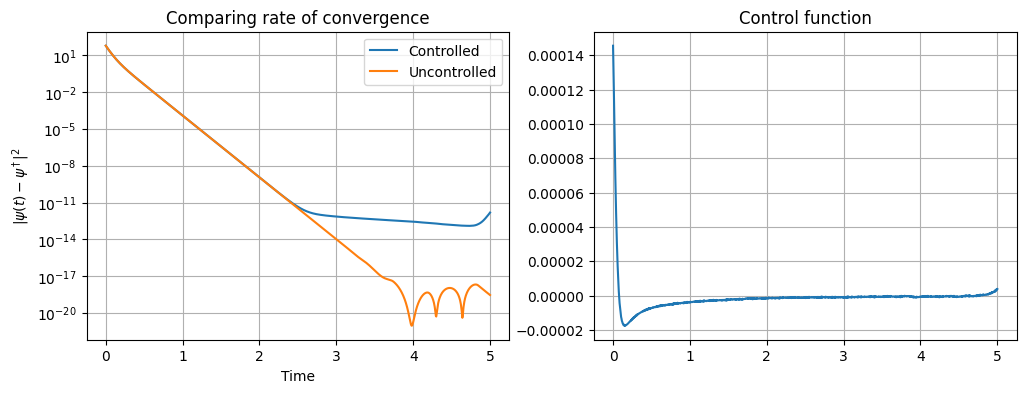

In [191]:
diff_control = np.sum((result_control['a_vals'] - solver2d.a_dag)**2, axis=1)
diff_nocontrol = np.sum((result['a_vals'] - solver2d.a_dag)**2, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(result_control['time'], diff_control, label='Controlled')
ax[0].plot(result['time'], diff_nocontrol, label='Uncontrolled')

ax[0].set_xlabel('Time')
ax[0].set_ylabel(r'$|\psi(t) - \psi^\dagger|^2$')
ax[0].set_title('Comparing rate of convergence')
ax[0].legend()
ax[0].grid(True)
ax[0].set_yscale('log')

ax[1].plot(result_control['time'], result_control['u_vals'][:, 0])
ax[1].grid(True)
ax[1].set_title("Control function")

plt.show()

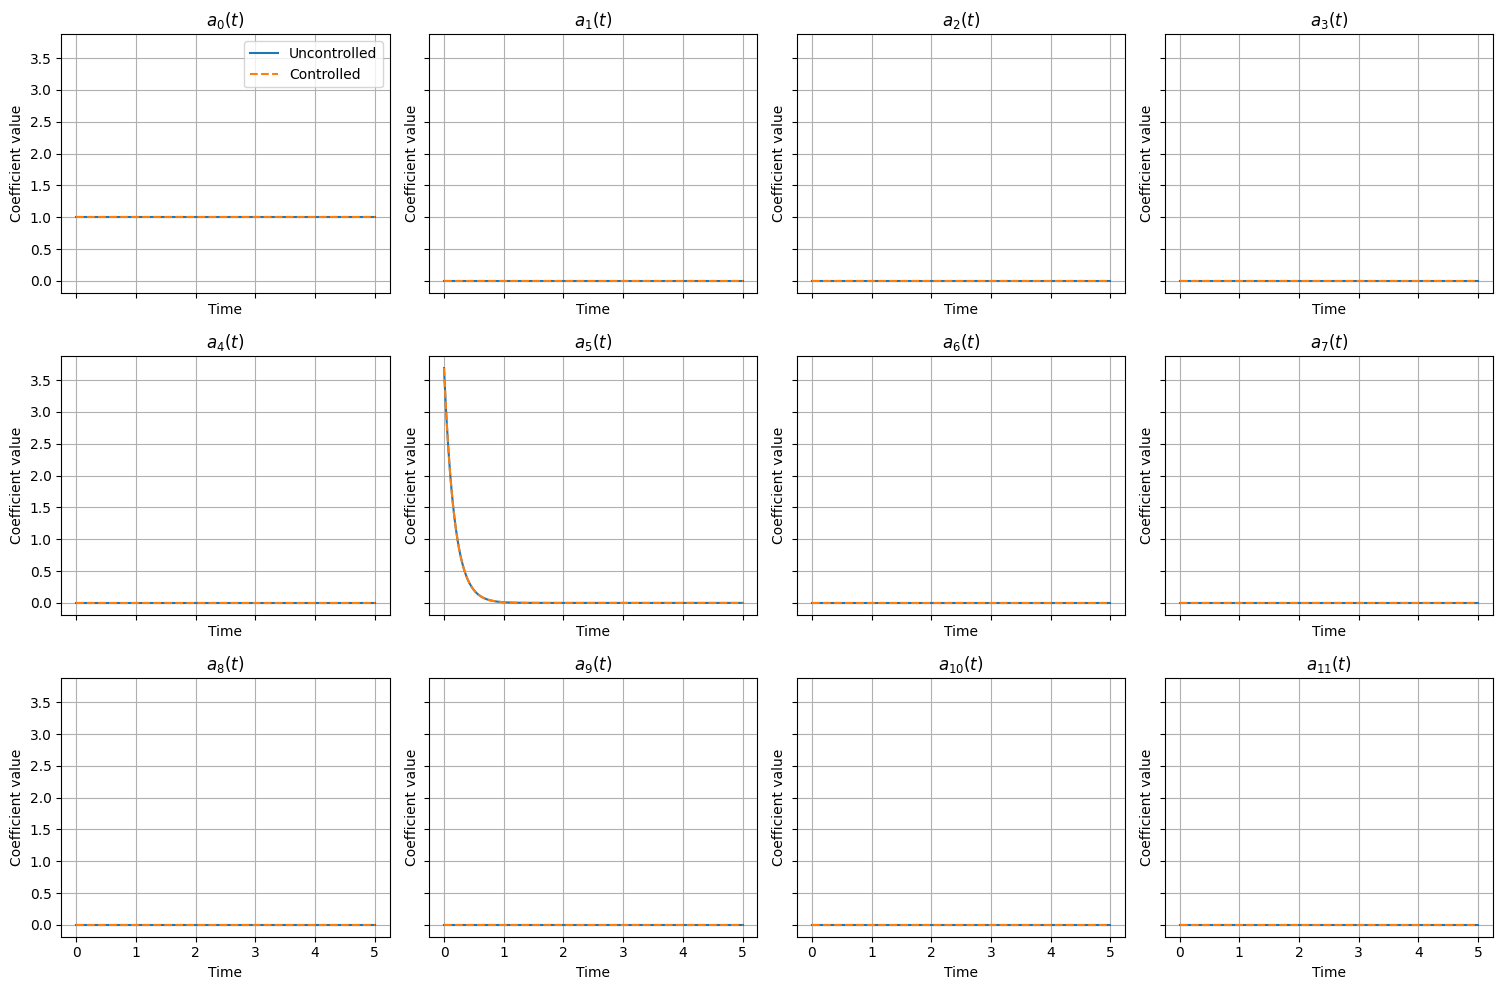

In [193]:
num_plots = 12
rows, cols = 3, 4  # 3 rows x 4 cols = 12 subplots

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(num_plots):
    ax = axes[i]
    ax.plot(result['time'], result['a_vals'][:, i], label='Uncontrolled', color='C0')
    ax.plot(result_control1['time'], result_control['a_vals'][:, i], label='Controlled', color='C1', linestyle='--')
    ax.set_title(f'$a_{{{i}}}(t)$')
    ax.set_xlabel('Time')
    ax.set_ylabel('Coefficient value')
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

## Example 5: Multi-stable in 2d. Here we want to take a_1(0) different then 0.

In [2]:
potential_expr_str = "4*x^6-12*x^4+3*x^2+4*y^6-12*y^4+3*y^2+6"
approximator = WolframNDEigensystemApproximator(
    potential_expr=potential_expr_str,
    L=(3.0,3.0),
    N=(500, 500),
    sigma=1.0,
    options={"MaxCellMeasure": 0.05}
)

eigeninfo = approximator.solve_eigen(num_eigen=50, derivative=True)

In [5]:
def potential(X, Y):
    return (X**2 - 1.5)**2 + (Y**2 - 1.5)**2

def integrand(r):
    return r * np.exp(-1 / (1 - r**2 / 4))

integral_value, _ = quad(integrand, 0, 2)
C = 1 / (2 * np.pi * integral_value)

def rho_0(X, Y):
    r2 = (X + 0.2)**2 + (Y - 0.5)**2  # Shift the center to (0.5, 0.5)
    out = np.zeros_like(r2)
    mask = r2 < 4  # Ensure the support remains within r < 2
    out[mask] = C * np.exp(-1 / (1 - r2[mask] / 4))
    return out

nabla_alpha_list = [lambda X, Y: (np.ones_like(X), np.ones_like(Y))]
nabla_V = lambda X, Y: (4*(X**2 - 1.5)*X, 4*(Y**2 - 1.5)*Y)

solver2d = SchrodingerControlSolver(
    approximator=approximator,
    num_eigen=50,
    potential=potential,
    rho_0=rho_0,
    rho_dag=None,
    kappa=5.0,
    nu=1e-4,
    nabla_alpha_list=None,
    nabla_V=nabla_V,
    correct_lambda0=True,
    eigeninfo=eigeninfo,
    compute_alpha=2
)

In [7]:
T = 5.0
result_control = solver2d.solve(
    T=T, 
    max_iter=500, 
    tol=1e-4, 
    time_eval=np.linspace(0, T, 1001), 
    verbose=True, 
    learning_rate_kwargs={'method': 'bb', 'gamma': 1}, 
    inicialization=True
)

result = solver2d.solve(
    T=T, 
    max_iter=200, 
    tol=1e-4, 
    time_eval=np.linspace(0, T, 1001), 
    verbose=True, 
    control_funcs=[lambda t: np.zeros_like(t)], 
    optimise=False
)

WARNING - Using LQR inicialization
Iteration 1: ||grad|| = 2.628e+00, gamma = 1
Iteration 2: ||grad|| = 2.285e+00, gamma = 0.5368601032283927
Iteration 3: ||grad|| = 2.943e-01, gamma = 0.4888744900150622
Iteration 4: ||grad|| = 1.238e-01, gamma = 0.5121401625251482
Iteration 5: ||grad|| = 1.061e-01, gamma = 2.177153600912867
Iteration 6: ||grad|| = 7.057e-02, gamma = 2.480655526457309
Iteration 7: ||grad|| = 6.217e-02, gamma = 5.437626786394311
Iteration 8: ||grad|| = 9.649e-02, gamma = 1.2162930061088253
Iteration 9: ||grad|| = 1.186e-01, gamma = 0.5324660640982003
Iteration 10: ||grad|| = 4.285e-02, gamma = 0.5591994685594893
Iteration 11: ||grad|| = 4.164e-02, gamma = 1.8615392435162212
Iteration 12: ||grad|| = 3.891e-02, gamma = 18.27268749877176
Iteration 13: ||grad|| = 4.256e-02, gamma = 7.883324367544028
Iteration 14: ||grad|| = 5.646e-01, gamma = 0.4804353615050884
Iteration 15: ||grad|| = 2.091e-02, gamma = 0.47726673258218605
Iteration 16: ||grad|| = 1.855e-02, gamma = 0.6896

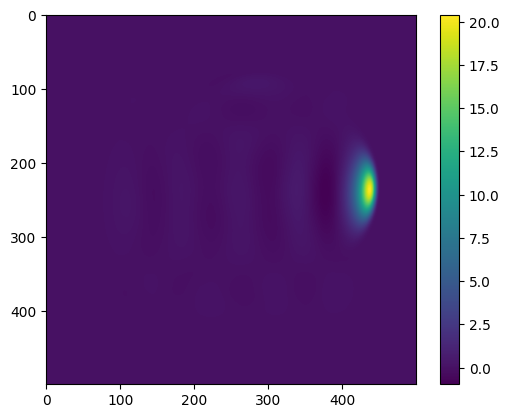

In [8]:
X, Y = np.meshgrid(solver2d.x, solver2d.y, indexing='ij') 
fig = plt.figure()
im = plt.imshow(rho_0(X, Y) / np.sqrt(solver2d.rho_infty(X,Y)) - result['psi'][0])
fig.colorbar(im)

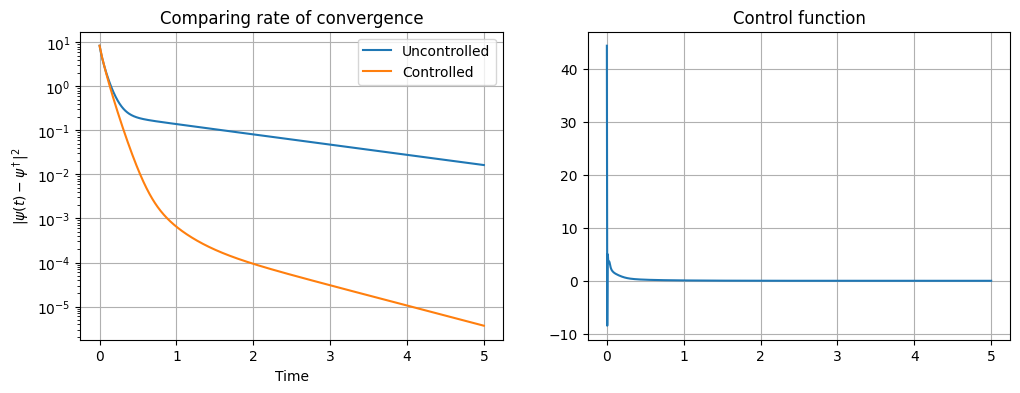

In [9]:
diff_control = np.sum((result_control['a_vals'] - solver2d.a_dag)**2, axis=1)
diff_nocontrol = np.sum((result['a_vals'] - solver2d.a_dag)**2, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(result['time'], diff_nocontrol, label='Uncontrolled')
ax[0].plot(result_control['time'], diff_control, label='Controlled')

ax[0].set_xlabel('Time')
ax[0].set_ylabel(r'$|\psi(t) - \psi^\dagger|^2$')
ax[0].set_title('Comparing rate of convergence')
ax[0].legend()
ax[0].grid(True)
ax[0].set_yscale('log')

ax[1].plot(result_control['time'], result_control['u_vals'][:, 0])
ax[1].grid(True)
ax[1].set_title("Control function")

plt.show()

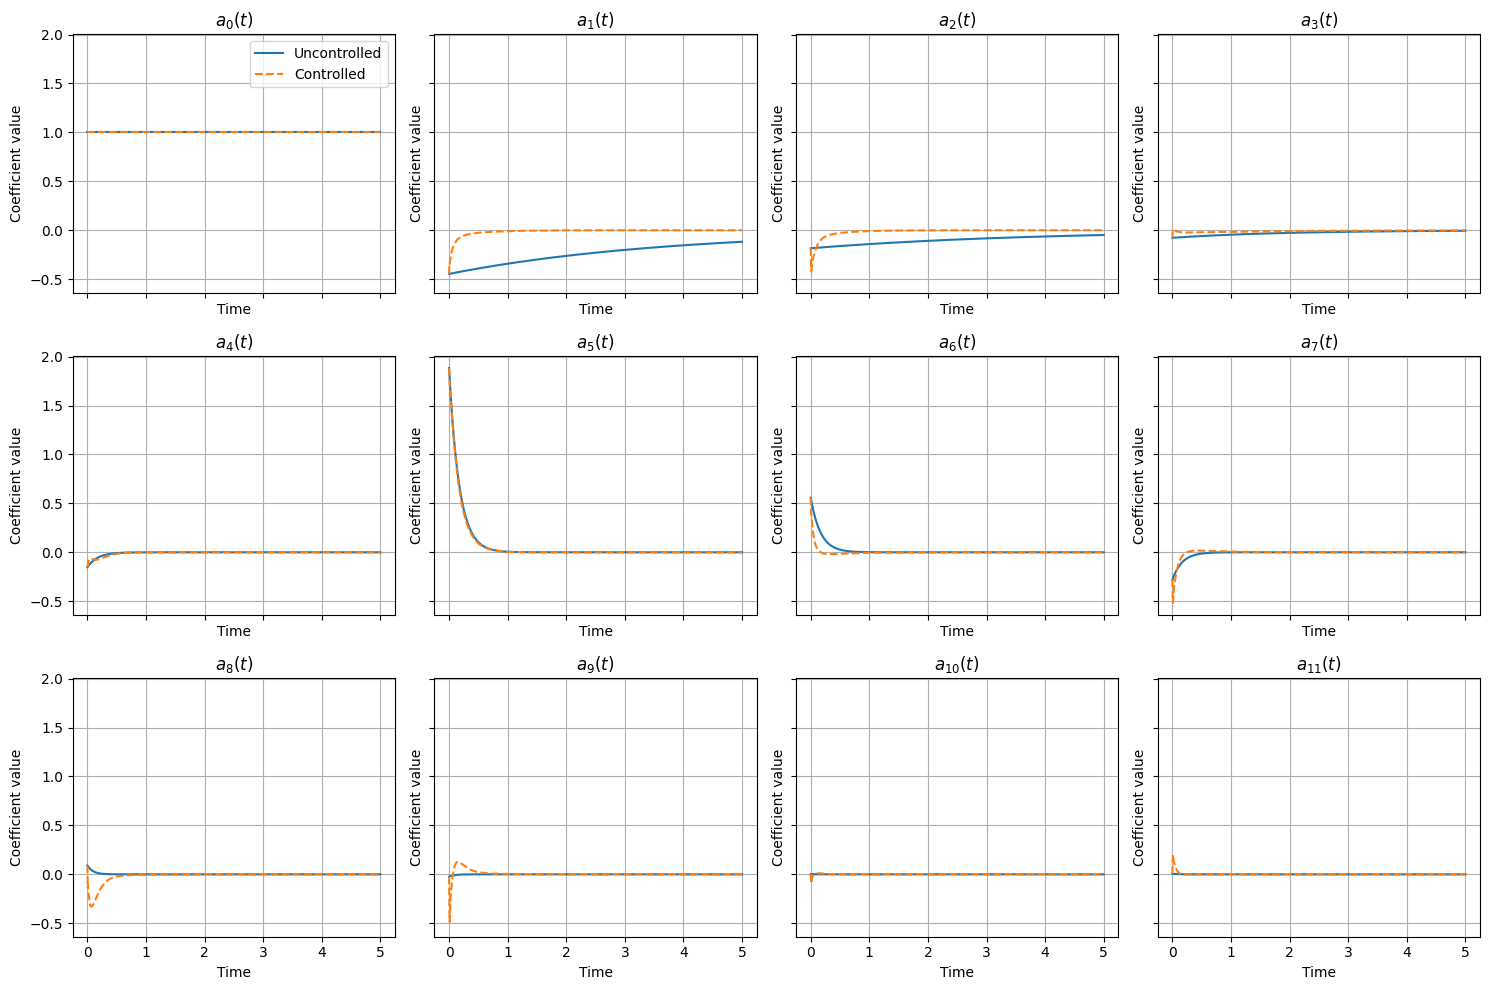

In [11]:
num_plots = 12
rows, cols = 3, 4  # 3 rows x 4 cols = 12 subplots

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(num_plots):
    ax = axes[i]
    ax.plot(result['time'], result['a_vals'][:, i], label='Uncontrolled', color='C0')
    ax.plot(result_control['time'], result_control['a_vals'][:, i], label='Controlled', color='C1', linestyle='--')
    ax.set_title(f'$a_{{{i}}}(t)$')
    ax.set_xlabel('Time')
    ax.set_ylabel('Coefficient value')
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

## Example 6: Normal distribution example.

In [12]:
a, b, x, y = sp.symbols('a b x y')
potential_sym = 0.5 * (a*x**2 + b*y**2)

potential_x = sp.diff(potential_sym, x)
potential_y = sp.diff(potential_sym, y)
laplace_V = sp.diff(potential_sym, x, 2) + sp.diff(potential_sym, y, 2)
gradV_sq = potential_x**2 + potential_y**2
expression_2d = 0.25 * gradV_sq - 0.5 * laplace_V

print("Gradient components:")
print("dV/dx =", sp.simplify(potential_x))
print("dV/dy =", sp.simplify(potential_y))
print("W =", sp.simplify(expression_2d))

Gradient components:
dV/dx = 1.0*a*x
dV/dy = 1.0*b*y
W = 0.25*a**2*x**2 - 0.5*a + 0.25*b**2*y**2 - 0.5*b


In [126]:
a_value = 1
b_value = 0.1

def potential(X, Y):
    return 0.5 * (a_value*X*X + b_value*Y*Y)

potential_expr_str = f"{0.25*a_value**2}*x^2 + {0.25*b_value**2:.6f}*y^2 - {0.5*(a_value + b_value)}"

approximator_normal = WolframNDEigensystemApproximator(
    potential_expr=potential_expr_str,
    L=(2.0, 25.0),
    N=(100, 1000),
    sigma=1.0,
    options={"MaxCellMeasure": 1.0}
)

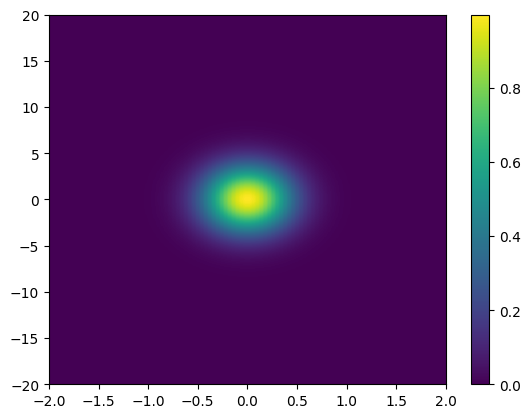

In [127]:
X, Y = np.meshgrid(approximator_normal.x, approximator_normal.y, indexing='ij')

fig = plt.figure()
im = plt.imshow(np.exp(-potential(X, Y)).T, origin='lower',
                extent=[-2, 2, -25, 25], aspect='auto')
fig.colorbar(im)
plt.show()

In [128]:
eigeninfo_normal = approximator_normal.solve_eigen(num_eigen=50, derivative=True)

In [129]:
eigeninfo_normal[0]

array([1.70235067e-03, 1.01757825e-01, 2.01871521e-01, 3.02047116e-01,
       4.02288219e-01, 5.02598415e-01, 6.02981559e-01, 7.03443492e-01,
       8.03999933e-01, 9.04705295e-01, 1.00573385e+00, 1.10754560e+00,
       1.21109836e+00, 1.31792716e+00, 1.42990281e+00, 1.54876349e+00,
       1.67576302e+00, 1.81162824e+00, 1.95671742e+00, 2.11119911e+00,
       2.27517106e+00, 2.44872085e+00, 2.63195208e+00, 2.82499362e+00,
       3.02800196e+00, 3.24116060e+00, 3.46467856e+00, 3.69878840e+00,
       3.94374416e+00, 4.19981906e+00, 4.46730297e+00, 4.74649964e+00,
       5.03772357e+00, 5.34129660e+00, 5.65754421e+00, 5.98679162e+00,
       6.32935977e+00, 6.68556142e+00, 7.05569732e+00, 7.44005289e+00,
       7.83889507e+00, 8.25246952e+00, 8.68099717e+00, 9.12466846e+00,
       9.58362994e+00, 1.00579544e+01, 1.05473861e+01, 1.10536725e+01,
       1.11664268e+01, 1.12664324e+01])

In [132]:
def integrand(r):
    return r * np.exp(-1 / (1 - r**2 / 4))

integral_value, _ = quad(integrand, 0, 2)
C = 1 / (2 * np.pi * integral_value)

def rho_0(X, Y):
    r2 = (X + 0.2)**2 + (Y - 0.5)**2  # Shift the center to (0.5, 0.5)
    out = np.zeros_like(r2)
    mask = r2 < 4  # Ensure the support remains within r < 2
    out[mask] = C * np.exp(-1 / (1 - r2[mask] / 4))
    return out

nabla_V = lambda X, Y: (a_value*X, b_value*Y)

solver2d = SchrodingerControlSolver(
    approximator=approximator_normal,
    num_eigen=50,
    potential=potential,
    rho_0=rho_0,
    rho_dag=None,
    kappa=5.0,
    nu=1e-4,
    nabla_alpha_list=None,
    nabla_V=nabla_V,
    correct_lambda0=True,
    eigeninfo=eigeninfo_normal,
    compute_alpha=2
)

In [133]:
T = 5.0
result_control = solver2d.solve(
    T=T, 
    max_iter=500, 
    tol=1e-4, 
    time_eval=np.linspace(0, T, 1001), 
    verbose=True, 
    learning_rate_kwargs={'method': 'bb', 'gamma': 1}, 
    inicialization=True
)

result = solver2d.solve(
    T=T, 
    max_iter=200, 
    tol=1e-4, 
    time_eval=np.linspace(0, T, 1001), 
    verbose=True, 
    control_funcs=[lambda t: np.zeros_like(t)], 
    optimise=False
)

WARNING - Using LQR inicialization
Iteration 1: ||grad|| = 5.214e-01, gamma = 1
Iteration 2: ||grad|| = 3.799e-01, gamma = 2.3795328965938114
Iteration 3: ||grad|| = 1.314e+00, gamma = 0.44995844155240206
Iteration 4: ||grad|| = 3.205e-01, gamma = 0.36823887831358093
Iteration 5: ||grad|| = 2.379e-01, gamma = 1.1814125181098054
Iteration 6: ||grad|| = 2.405e-01, gamma = 0.5865739115803669
Iteration 7: ||grad|| = 1.150e-01, gamma = 0.469403015337915
Iteration 8: ||grad|| = 9.494e-02, gamma = 0.6622598586453047
Iteration 9: ||grad|| = 8.813e-02, gamma = 1.9946396796446504
Iteration 10: ||grad|| = 7.414e-02, gamma = 5.785425592147393
Iteration 11: ||grad|| = 8.844e-02, gamma = 1.9147416097048469
Iteration 12: ||grad|| = 1.703e-01, gamma = 0.5906443962448695
Iteration 13: ||grad|| = 4.808e-02, gamma = 0.6391112354304262
Iteration 14: ||grad|| = 4.556e-02, gamma = 0.6471137121588888
Iteration 15: ||grad|| = 4.445e-02, gamma = 2.5648669402708197
Iteration 16: ||grad|| = 4.087e-02, gamma = 13

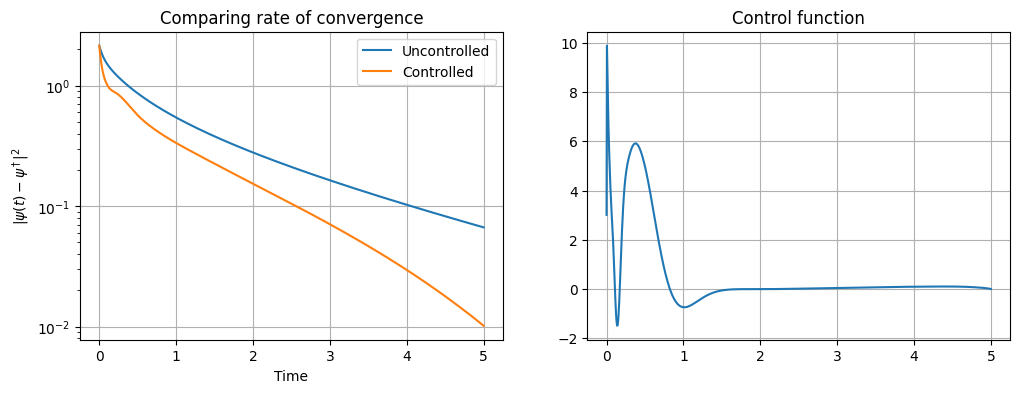

In [134]:
diff_control = np.sum((result_control['a_vals'] - solver2d.a_dag)**2, axis=1)
diff_nocontrol = np.sum((result['a_vals'] - solver2d.a_dag)**2, axis=1)

fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(result['time'], diff_nocontrol, label='Uncontrolled')
ax[0].plot(result_control['time'], diff_control, label='Controlled')

ax[0].set_xlabel('Time')
ax[0].set_ylabel(r'$|\psi(t) - \psi^\dagger|^2$')
ax[0].set_title('Comparing rate of convergence')
ax[0].legend()
ax[0].grid(True)
ax[0].set_yscale('log')

ax[1].plot(result_control['time'], result_control['u_vals'][:, 0])
ax[1].grid(True)
ax[1].set_title("Control function")

plt.show()

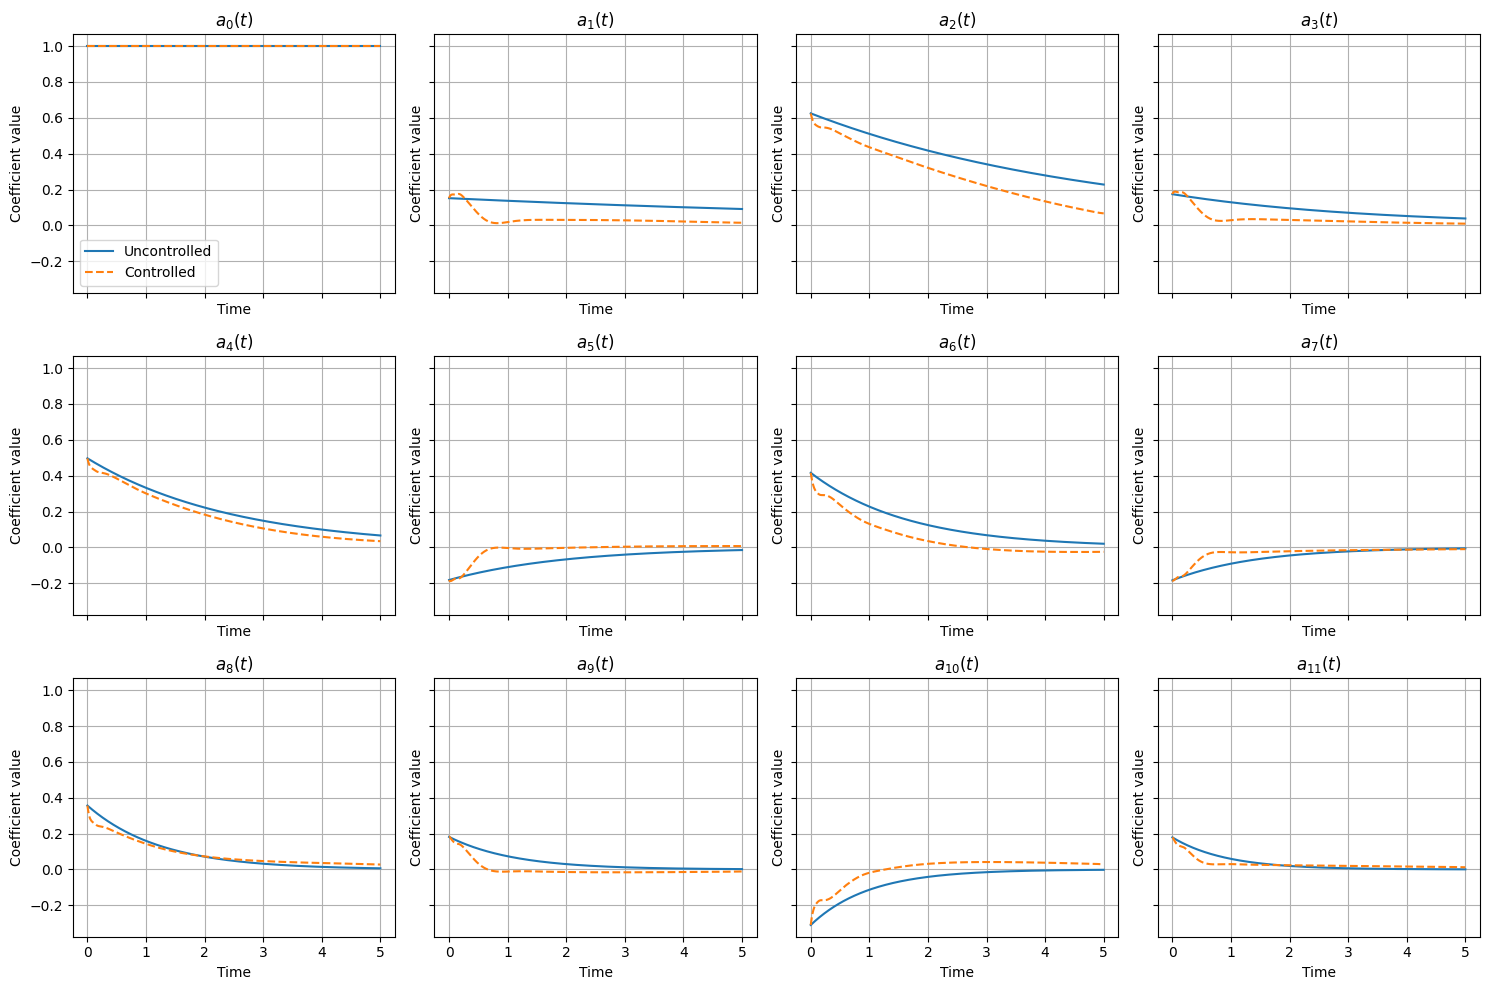

In [136]:
num_plots = 12
rows, cols = 3, 4  # 3 rows x 4 cols = 12 subplots

fig, axes = plt.subplots(rows, cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(num_plots):
    ax = axes[i]
    ax.plot(result['time'], result['a_vals'][:, i], label='Uncontrolled', color='C0')
    ax.plot(result_control['time'], result_control['a_vals'][:, i], label='Controlled', color='C1', linestyle='--')
    ax.set_title(f'$a_{{{i}}}(t)$')
    ax.set_xlabel('Time')
    ax.set_ylabel('Coefficient value')
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.show()

## Understanding the cost functional

Here I will understand $u(t) = A e^{-\lambda t}$ with parameters $A$ and $\lambda$. The idea is to plot the cost functional on $A$ and $\lambda$. 

In [23]:
approximator = WolframNDEigensystemApproximator(
    potential_expr="4*x^6 - 12*x^4 + 3*x^2 + 3",
    L=4.0,
    N=2000,       
    sigma=1.0,
    options={"MaxCellMeasure": 0.05}
)

def potential(x): return (x**2 - 1.5)**2

from scipy.integrate import quad
def _bump_scalar(x):
    """Scalar version for integration."""
    return np.exp(-1/(1 - x**2)) if np.abs(x) < 1 else 0.0
norm, _ = quad(_bump_scalar, -1, 1)
C = 1 / norm
def rho_0(x):
    y = np.zeros_like(x, dtype=float)
    mask = np.abs(x-1) < 1
    y[mask] = C * np.exp(-1/(1 - (x[mask]-1)**2))
    return y
    
def nabla_alpha(x):
    return np.sin(0.5*x)/(1 + x**4)

nabla_alpha_list = [nabla_alpha]

solver = SchrodingerControlSolver(
    approximator=approximator,
    num_eigen=20,
    potential=potential,
    rho_0=rho_0,
    rho_dag=None,
    kappa=0,
    nu=1e-3,
    nabla_alpha_list=nabla_alpha_list,
    nabla_V=lambda x: 4*(x**2 - 1.5)*x,
    correct_lambda0=True
)

In [24]:
T = 5.0
time_eval = np.linspace(0, T, 1000)

A_values = np.linspace(-100, 100, 31)
lambda_values = np.linspace(0.5, 10, 31)

cost_matrix = np.zeros((len(A_values), len(lambda_values)))

for i, A in enumerate(A_values):
    for j, lam in enumerate(lambda_values):
        u_func = lambda t, A=A, lam=lam: A * np.exp(-lam * t)
        cost = solver.compute_cost_functional([u_func], T, time_eval)
        cost_matrix[i, j] = cost

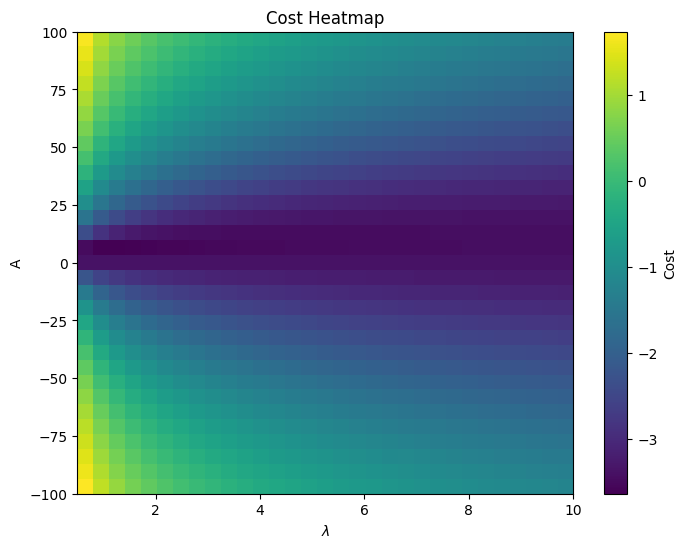

In [25]:
plt.figure(figsize=(8, 6))
plt.imshow(np.log(cost_matrix), origin='lower', extent=[lambda_values[0], lambda_values[-1], A_values[0], A_values[-1]],
           aspect='auto', cmap='viridis')
plt.xlabel(r'$\lambda$')
plt.ylabel('A')
plt.title('Cost Heatmap')
cbar = plt.colorbar()
cbar.set_label('Cost')
plt.show()